# Compare tau decay distributions between Tauola and IceCube simulations

In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyhepmc
from collections import Counter

## Load decays

In [184]:
particle_info = pd.read_csv('genie_tau_decays_particles.csv')

In [195]:
with pyhepmc.open("tauola_output2.dat", "r") as f:
    evt = f.read()
    evt2 = f.read()
    evt3 = f.read()

In [196]:
evt

<GenEvent momentum_unit=1, length_unit=0, event_number=0, particles=6, vertices=2, run_info=GenRunInfo(tools=[], weight_names=[], attributes={})>

In [197]:
evt2

<GenEvent momentum_unit=1, length_unit=0, event_number=1, particles=8, vertices=3, run_info=GenRunInfo(tools=[], weight_names=[], attributes={})>

In [198]:
evt3

<GenEvent momentum_unit=1, length_unit=0, event_number=2, particles=6, vertices=2, run_info=GenRunInfo(tools=[], weight_names=[], attributes={})>

In [199]:
def load_hepmc(filename: str) -> pd.DataFrame:
    decay_products = []
    with pyhepmc.open(filename, "r") as f:
        # Iterate over all events
        for i, evt in enumerate(f):
            # Find the tau and identify its daughter tau neutrino
            for vertex in evt.vertices:
                # Check if there is a tau neutrino as incoming particle
                # If it is, skip the vertex
                if any(np.abs(p.pid) == 16 for p in vertex.particles_in):
                    continue
                
                event_number = evt.event_number

                # Find the daughter tau neutrino
                for daughter in vertex.particles_out:
                    # If it is not a final state particle, skip it
                    if daughter.status != 1:
                        continue

                    decay_products.append(
                        [
                            event_number,
                            daughter.pid,
                            daughter.momentum.e,
                            daughter.momentum.px,
                            daughter.momentum.py,
                            daughter.momentum.pz
                        ]
                    )
            
            if i % 10_000 == 0:
                print(i)

    return pd.DataFrame(decay_products, columns=['event_num', 'pdg', 'E', 'px', 'py', 'pz'])

decay_products = load_hepmc("tauola_output2.dat")
decay_products_nopol = load_hepmc("tauola_output_nopol.dat")
# If you want to save the DataFrame to a file, run this line
# decay_products.to_csv("tauola_decays.csv", index=False)
# decay_products_nopol.to_csv("tauola_decays_nopol.csv", index=False)


0
10000
20000
30000
40000
50000
60000
70000
0
10000
20000
30000
40000
50000
60000
70000


In [11]:
decay_products = pd.read_csv('tauola_decays.csv')
decay_products

,event_num,pdg,E,px,py,pz
0,0,-16,0.684091,-0.313670,0.493112,-0.355432
1,0,211,2.567605,0.289773,1.836672,1.765158
2,1,16,0.729982,-0.346327,-0.593313,-0.246598
3,1,-211,1.205996,-0.106781,-0.831778,0.855389
4,1,111,0.910825,-0.392252,-0.066269,0.808167
...,...,...,...,...,...,...
247662,76642,16,982.960721,-468.201297,-606.476242,-615.780717
247663,76642,-211,30.663205,-14.627516,-18.907154,-19.203333
247664,76642,-211,551.171493,-262.389373,-339.788376,-345.666996
247665,76642,211,333.975833,-158.859148,-205.851096,-209.592307


In [168]:
decay_products_nopol = pd.read_csv('tauola_decays_nopol.csv')
decay_products_nopol

,event_num,pdg,E,px,py,pz
0,0,-16,0.684091,0.557243,0.371363,-0.139461
1,0,211,2.567605,-0.581140,1.958421,1.549187
2,1,16,0.729982,0.424157,-0.320667,0.500037
3,1,-211,1.205996,-0.652705,-0.516590,0.861427
4,1,111,0.910825,-0.616812,-0.654103,0.055494
...,...,...,...,...,...,...
247662,76642,16,982.960721,-468.288985,-605.869507,-616.311079
247663,76642,-211,30.663205,-14.594667,-18.890032,-19.245131
247664,76642,-211,551.171493,-262.278443,-340.094584,-345.449979
247665,76642,211,333.975833,-158.884537,-206.227621,-209.202557


In [200]:
(
    np.isclose(decay_products["E"], decay_products_nopol["E"]).all(),
    np.isclose(decay_products["px"], decay_products_nopol["px"]).all(),
    np.isclose(decay_products["py"], decay_products_nopol["py"]).all(),
    np.isclose(decay_products["pz"], decay_products_nopol["pz"]).all(),
)

(True, False, False, False)

It seems like the energies of the particles are exactly the same for polarized and unpolarized, but the directions differ. This makes sense, I guess?

## Energy of tau neutrino

In [169]:
decays_icecube = particle_info.groupby("event_num").nth[3:]
nutau_icecube_e = decays_icecube.query("pdg == 16")["E"]
anti_nutau_icecube_e = decays_icecube.query("pdg == -16")["E"]

nutau_e = decay_products.query("pdg == 16")["E"]
anti_nutau_e = decay_products.query("pdg == -16")["E"]

nutau_nopol_e = decay_products_nopol.query("pdg == 16")["E"]
anti_nutau_nopol_e = decay_products_nopol.query("pdg == -16")["E"]

In [171]:
assert len(nutau_e) == len(nutau_icecube_e)
assert len(anti_nutau_e) == len(anti_nutau_icecube_e)
assert len(nutau_nopol_e) == len(nutau_icecube_e)
assert len(anti_nutau_nopol_e) == len(anti_nutau_icecube_e)

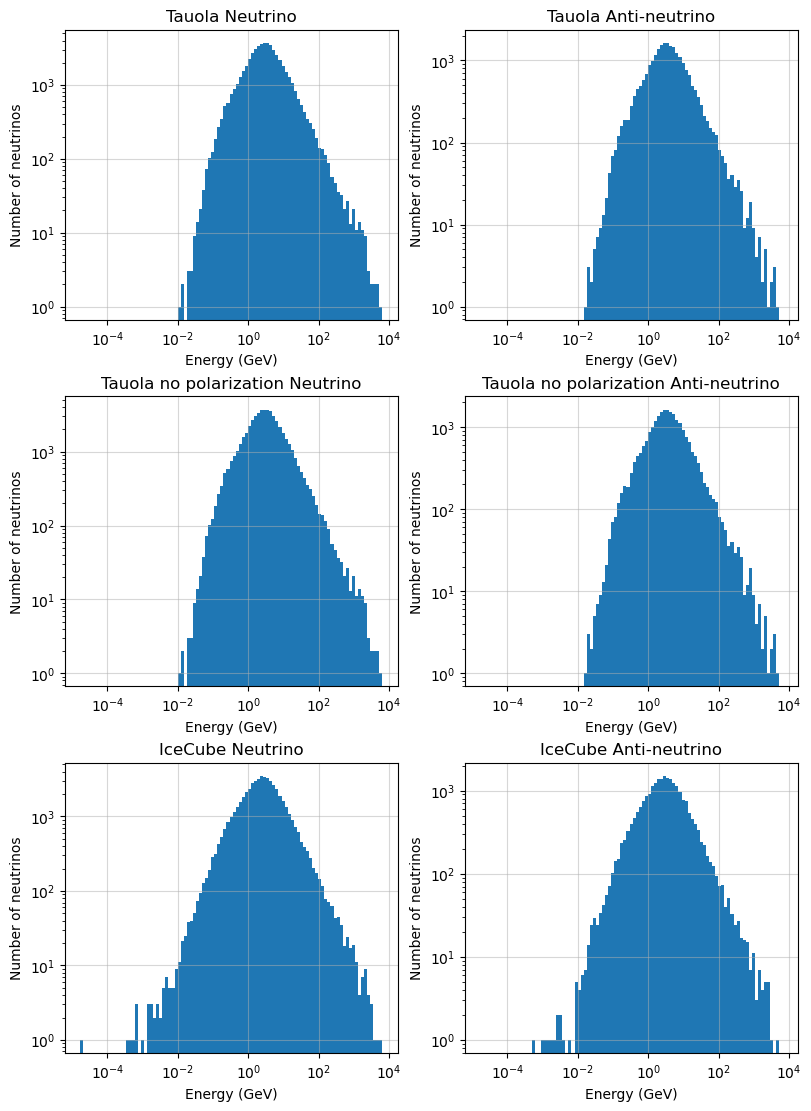

In [172]:
fig, axs = plt.subplots(figsize=(8, 11), nrows=3, ncols=2, layout="constrained")

min_energy = np.min(np.r_[nutau_e, anti_nutau_e, nutau_icecube_e, anti_nutau_icecube_e])
max_energy = np.max(np.r_[nutau_e, anti_nutau_e, nutau_icecube_e, anti_nutau_icecube_e])

for ax_row, label, lists, in zip(axs, ("Tauola", "Tauola no polarization", "IceCube"), ((nutau_e, anti_nutau_e), (nutau_nopol_e, anti_nutau_nopol_e), (nutau_icecube_e, anti_nutau_icecube_e))):
    for ax, energies, particle_type in zip(ax_row, lists, ("Neutrino", "Anti-neutrino")):
        ax.hist(energies, bins=np.geomspace(min_energy, max_energy, 100), label=f"{label} {particle_type}")
        ax.set_title(f"{label} {particle_type}")
        
for ax in axs.flat:
    ax.set(xscale="log", yscale="log", xlabel="Energy (GeV)", ylabel="Number of neutrinos")
    ax.grid(True, alpha=0.5)
    # ax.legend(fontsize="large")

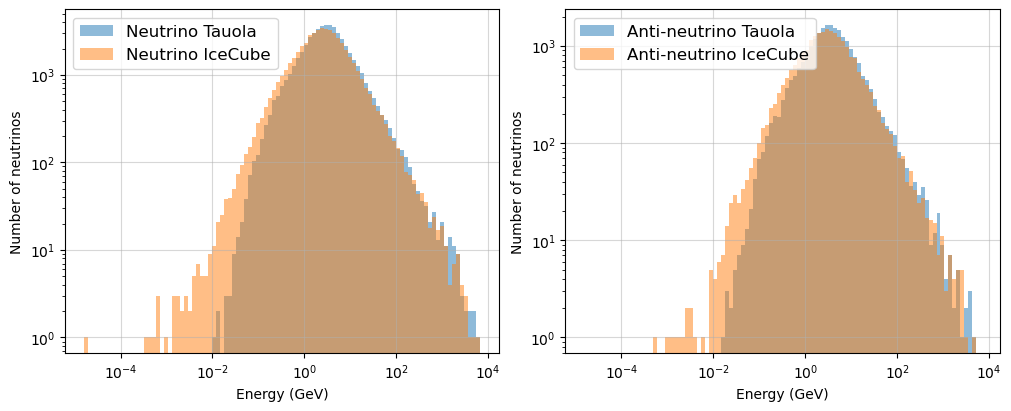

In [173]:
fig, axs = plt.subplots(figsize=(10, 4), nrows=1, ncols=2, layout="constrained")

min_energy = np.min(np.r_[nutau_e, anti_nutau_e, nutau_icecube_e, anti_nutau_icecube_e])
max_energy = np.max(np.r_[nutau_e, anti_nutau_e, nutau_icecube_e, anti_nutau_icecube_e])

for ax, label, lists, in zip(axs, ("Neutrino", "Anti-neutrino"), ((nutau_e, nutau_icecube_e), (anti_nutau_e, anti_nutau_icecube_e))):
    for energies, particle_type in zip(lists, ("Tauola", "IceCube")):
        ax.hist(energies, bins=np.geomspace(min_energy, max_energy, 100), label=f"{label} {particle_type}", alpha=0.5)
        # ax.set_title(f"{label} {particle_type}")
        
for ax in axs.flat:
    ax.set(xscale="log", yscale="log", xlabel="Energy (GeV)", ylabel="Number of neutrinos")
    ax.grid(True, alpha=0.5)
    ax.legend(fontsize="large")

It seems like neutrinos tend to have lower energies for IceCube compared to Tauola. This would mean that the IceCube simulations overestimate the energy deposited in the detector.

## Low energy incoming tau neutrinos

In [29]:
# Select only events where the incoming neutrino has energy < 5 GeV
low_energy_events = particle_info.groupby("event_num").filter(lambda df: df.iloc[1, 2] < 5.)

In [30]:
decays_icecube_low_energy = decays_icecube[decays_icecube["event_num"].isin(low_energy_events["event_num"])]
nutau_icecube_e_le = decays_icecube_low_energy.query("pdg == 16")["E"]
anti_nutau_icecube_e_le = decays_icecube_low_energy.query("pdg == -16")["E"]

decays_low_energy = decay_products[decay_products["event_num"].isin(low_energy_events["event_num"])]
nutau_e_le = decays_low_energy.query("pdg == 16")["E"]
anti_nutau_e_le = decays_low_energy.query("pdg == -16")["E"]

/tmp/ipykernel_5818/3877334160.py:23: RuntimeWarning: divide by zero encountered in divide
  ax.stairs(hist_list[0] / hist_list[1], bins, color="k")
/tmp/ipykernel_5818/3877334160.py:23: RuntimeWarning: invalid value encountered in divide
  ax.stairs(hist_list[0] / hist_list[1], bins, color="k")


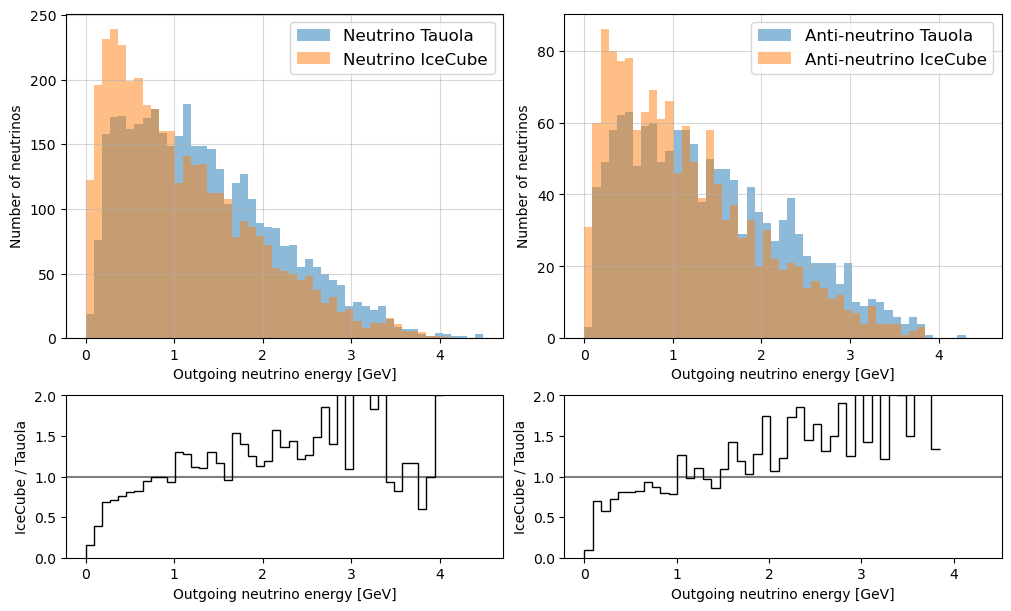

In [55]:
fig, axs = plt.subplots(figsize=(10, 6), nrows=2, ncols=2, layout="constrained", gridspec_kw=dict(height_ratios=(2, 1)))

min_energy = np.min(np.r_[nutau_e_le, anti_nutau_e_le, nutau_icecube_e_le, anti_nutau_icecube_e_le])
max_energy = np.max(np.r_[nutau_e_le, anti_nutau_e_le, nutau_icecube_e_le, anti_nutau_icecube_e_le])
bins = np.linspace(min_energy, max_energy, 50)

histograms = []
for ax, label, lists, in zip(axs[0, :], ("Neutrino", "Anti-neutrino"), ((nutau_e_le, nutau_icecube_e_le), (anti_nutau_e_le, anti_nutau_icecube_e_le))):
    ax_hists = []
    for energies, particle_type in zip(lists, ("Tauola", "IceCube")):
        e_hist, *_ = ax.hist(energies, bins=bins, label=f"{label} {particle_type}", alpha=0.5)
        ax_hists.append(e_hist)
        # ax.set_title(f"{label} {particle_type}")
    histograms.append(ax_hists)

for ax in axs[0, :]:
    ax.set(xlabel="Outgoing neutrino energy [GeV]", ylabel="Number of neutrinos")
    ax.grid(True, alpha=0.5)
    ax.legend(fontsize="large")

# Plot ratio of the histograms in the lower row
for ax, hist_list in zip(axs[1, :], histograms):
    ax.stairs(hist_list[0] / hist_list[1], bins, color="k")
    ax.axhline(1, c="k", alpha=0.5)
    ax.set(ylim=(0, 2), xlabel="Outgoing neutrino energy [GeV]", ylabel="IceCube / Tauola")


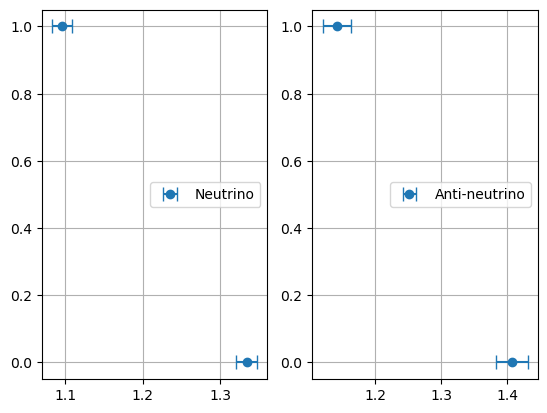

In [53]:
# Plot dots of mean energy with standard deviations. Each row should be a different dataset
# print(f"{np.mean(nutau_e)} +- {np.std(nutau_e)/np.sqrt(len(nutau_e)-1)}, {np.mean(nutau_icecube_e)} +- {np.std(nutau_icecube_e)/np.sqrt(len(nutau_e)-1)}")
fig, (ax, ax_anti) = plt.subplots(ncols=2)
ax.errorbar(
    y=np.arange(2),
    x=[np.mean(nutau_e_le), np.mean(nutau_icecube_e_le)],
    xerr=[np.std(nutau_e_le)/np.sqrt(len(nutau_e_le)-1), np.std(nutau_icecube_e_le)/np.sqrt(len(nutau_icecube_e_le)-1)],
    fmt="o",
    # add vertical lines at the end of the error bars
    capsize=5,
    label="Neutrino"
)
ax.grid()
ax.legend(loc="center right")

ax_anti.errorbar(
    y=np.arange(2),
    x=[np.mean(anti_nutau_e_le), np.mean(anti_nutau_icecube_e_le)],
    xerr=[np.std(anti_nutau_e_le)/np.sqrt(len(anti_nutau_e_le)-1), np.std(anti_nutau_icecube_e_le)/np.sqrt(len(anti_nutau_icecube_e_le)-1)],
    fmt="o",
    # add vertical lines at the end of the error bars
    capsize=5,
    label="Anti-neutrino"
)
ax_anti.grid()
ax_anti.legend(loc="center right")

For low energy primary tau neutrinos, the difference in mean energy is statistically significant between the two simulations. This couls mean that the spin polarization has a meaningful effect on the secondary neutrino energy.

In [57]:
particle_info.groupby("event_num").nth(1)

,event_num,pdg,E,px,py,pz
1,0,-16,3.730323,0.185260,3.295873,1.737299
6,1,16,3.725654,-1.656092,-2.943322,1.573121
13,2,16,3.528632,-2.419746,-2.330455,-1.079378
18,3,16,3.882620,-0.162095,-0.282077,-3.868966
25,4,16,3.909540,0.001797,-0.855136,-3.814871
...,...,...,...,...,...,...
447097,76638,-16,1420.859081,-563.321344,-862.807899,-978.300630
447103,76639,16,5830.060163,-5542.246831,-1435.699600,-1100.848866
447109,76640,-16,1898.861298,1372.595075,-1307.442511,-110.684538
447115,76641,16,2171.189851,-1055.061515,1112.683486,1537.155174


In [150]:
# Sort the events in particle_info based on the energy of the incoming neutrino
current_bin = 0
bin_step = 10
max_bin = 1000
bins = np.arange(current_bin, max_bin+bin_step+1e-6, bin_step)
bin_events = [[]]

for nu in particle_info.groupby("event_num").nth(1).sort_values("E").itertuples():
    if nu.E > current_bin + bin_step:
        current_bin += bin_step
        if current_bin > max_bin:
            break
        bin_events.append([])
    
    bin_events[-1].append(nu.event_num)

In [151]:
# For each energy bin, calculate the mean energy of the secondary neutrino

def get_energies(data, bin_events) -> tuple[list[float], list[float]]:
    mean_energies = []
    std_energies = []
    
    for events in bin_events:
        if len(events) <= 1:
            mean_energies.append(np.nan)
            std_energies.append(np.nan)
            continue

        decays = data[data["event_num"].isin(events)]
        mean_energies.append(np.mean(decays.query("abs(pdg) == 16")["E"]))
        std_energies.append(np.std(decays.query("abs(pdg) == 16")["E"])/np.sqrt(len(events)-1))
    return mean_energies, std_energies

# Tauola
mean_energies, std_energies = get_energies(decay_products, bin_events)
# IceCube
mean_energies_ic, std_energies_ic = get_energies(particle_info.groupby("event_num").nth[3:], bin_events)

In [152]:
len(mean_energies), len(bins)

(101, 102)

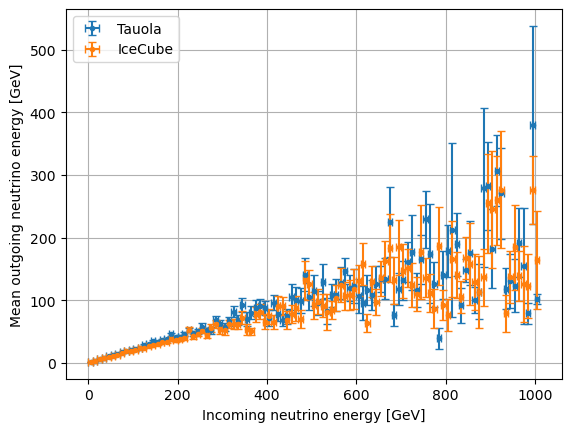

In [162]:
# Plot mean energies with standard deviations
fig, ax = plt.subplots()
plot_settings = dict(
    x=(bins[1:] + bins[:-1])/2,
    xerr=bin_step/2,
    fmt="o",
    # add vertical lines at the end of the error bars
    capsize=3,
    markersize=3,
)

ax.errorbar(
    y=mean_energies,
    yerr=std_energies,
    label="Tauola",
    **plot_settings,
)
ax.errorbar(
    y=mean_energies_ic,
    yerr=std_energies_ic,
    label="IceCube",
    **plot_settings,
)
ax.set(xlabel="Incoming neutrino energy [GeV]", ylabel="Mean outgoing neutrino energy [GeV]")
ax.legend()
ax.grid()

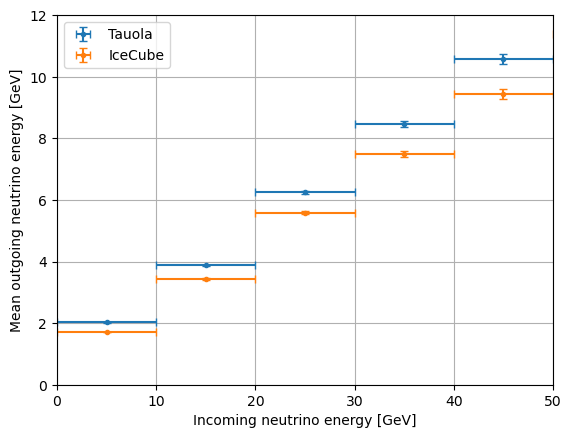

In [165]:
ax.set(xlim=(0, 50), ylim=(0, 12))
fig

Clearly for lower energies, the two decay simulations differ significantly from each other.

## Branching ratios for Tauola events

In [20]:
c = Counter(tuple(sorted(a.tolist())) for i, a in decay_products.groupby("event_num")["pdg"])

In [21]:
n_taus = (particle_info["pdg"] == 15).sum()
n_anti_taus = (particle_info["pdg"] == -15).sum()
n_taus, n_anti_taus

(53172, 23471)

In [22]:
br = {}
for pdgs, n in c.items():
    if 16 in pdgs:
        br[pdgs] = n / n_taus
    elif -16 in pdgs:
        br[pdgs] = n / n_anti_taus
    else:
        raise ValueError("No tau in the event")
br

{(-16, 211): 0.11000809509607601,
 (-211, 16, 111): 0.24992477243662078,
 (-211, 16): 0.1117505453998345,
 (-12, 11, 16): 0.1562288422477996,
 (-211, -211, 16, 211): 0.08920108327691266,
 (-16, 111, 211): 0.2545694687060628,
 (-211, -16, 211, 211): 0.08418899919049039,
 (-14, 13, 16): 0.17065372752576544,
 (-211, 16, 111, 111): 0.09294365455502897,
 (-16, -11, 12): 0.15593711388522005,
 (-211, -211, 16, 111, 211): 0.04500488979161965,
 (-16, -11, 12, 22): 0.028801499723062503,
 (-211, 16, 310): 0.0042315504400812455,
 (-16, -13, 14): 0.17148821950492096,
 (-211, 16, 130): 0.004269164221770857,
 (-211, -16, 111, 211, 211): 0.045630778407396363,
 (-211, 16, 130, 130): 0.00028210336267208303,
 (-16, 111, 111, 211): 0.09100592220186614,
 (-321, 16, 111): 0.004476040021063717,
 (-12, 11, 16, 22): 0.026724591890468666,
 (-211, 16, 111, 310): 0.003046716316858497,
 (-321, -211, 16, 211): 0.005134281200631911,
 (-321, -211, 16, 321): 0.0014857443767396373,
 (-211, -211, 16, 111, 111, 111, 211)

In [23]:
pdg2name = {15: "tau-", 16: "nu_tau", 211: "pi+", -15: "tau+", -16: "nu_tau_bar", -211: "pi-", 111: "pi0", 13: "mu-", -13: "mu+", 14: "nu_mu", -14: "nu_mu_bar", 11: "e-", -11: "e+", 12: "nu_e", -12: "nu_e_bar", 22: 
            "gamma", 310: "K^0_S", 130: "K^0_L", 321: "K+", -321: "K-"}

for pdgs, n in br.items():
    for pdg in pdgs:
        print(pdg2name[pdg], end=" ")
    print(":", n*100)

nu_tau_bar pi+ : 11.0008095096076
pi- nu_tau pi0 : 24.99247724366208
pi- nu_tau : 11.175054539983451
nu_e_bar e- nu_tau : 15.622884224779959
pi- pi- nu_tau pi+ : 8.920108327691265
nu_tau_bar pi0 pi+ : 25.456946870606277
pi- nu_tau_bar pi+ pi+ : 8.41889991904904
nu_mu_bar mu- nu_tau : 17.065372752576543
pi- nu_tau pi0 pi0 : 9.294365455502897
nu_tau_bar e+ nu_e : 15.593711388522005
pi- pi- nu_tau pi0 pi+ : 4.500488979161965
nu_tau_bar e+ nu_e gamma : 2.8801499723062505
pi- nu_tau K^0_S : 0.42315504400812454
nu_tau_bar mu+ nu_mu : 17.148821950492096
pi- nu_tau K^0_L : 0.42691642217708564
pi- nu_tau_bar pi0 pi+ pi+ : 4.563077840739636
pi- nu_tau K^0_L K^0_L : 0.028210336267208303
nu_tau_bar pi0 pi0 pi+ : 9.100592220186615
K- nu_tau pi0 : 0.44760400210637175
nu_e_bar e- nu_tau gamma : 2.6724591890468665
pi- nu_tau pi0 K^0_S : 0.3046716316858497
K- pi- nu_tau pi+ : 0.5134281200631912
K- pi- nu_tau K+ : 0.14857443767396372
pi- pi- nu_tau pi0 pi0 pi0 pi+ : 0.047017227112013844
nu_tau_bar pi0 p

KeyError: 221

In [24]:
# nutau_e = []
# anti_nutau_e = []
def identify_strange_events():
    with pyhepmc.open("tauola_output.dat", "r") as f:
        # Iterate over all events
        for i, evt in enumerate(f):
            # Find the tau and identify its daughter tau neutrino
            for vertex in evt.vertices:
                # Check if there is a tau neutrino as incoming particle
                # If it is, skip the vertex
                if any(np.abs(p.pid) == 16 for p in vertex.particles_in):
                    continue
                
                # Find the daughter tau neutrino
                for daughter in vertex.particles_out:
                    # If it is not a final state particle, skip it
                    if daughter.status != 1:
                        continue
                    
                    if np.abs(daughter.pid) not in {11, 12, 13, 14, 16, 111, 211, 22}:
                        return evt
                    
identify_strange_events()

<GenEvent momentum_unit=1, length_unit=0, event_number=32, particles=7, vertices=3, run_info=GenRunInfo(tools=[], weight_names=[], attributes={})>